<a href="https://colab.research.google.com/github/kxk302/HIV/blob/main/HIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/MyDrive/Colab Notebooks'

 Antecedents_4.png   hiv_rules.csv    MBA_files
 Consequent_4.png   'Kopie von MBA'   PlayGround.ipynb


In [ ]:
import math

import numpy as np
import pandas as pd

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Create a string representing nucleotide plus position
# Pivot the data so we have all sample strings on a single line
#
def preprocess_input_file(df_in, codon=True):
  if df_in is None or df_in.shape[0] == 0:
    return df_in
  
  df = df_in.copy()

  if codon:
    # Create a new column called 'Label', which is a string concatentation of Nucleotide and Position values. 
    df["Label"] = df["Nucleotide"].astype(str) + df["Position"].astype(str)
  else:
    # Create a new column called 'Label', which is a string concatentation of AminoAcid and Position values. 
    df["Label"] = df["AminoAcid"].astype(str) + df["Position"].astype(str)

  # We do not need Nucleotide, and Position columns anymore
  df = df[["Sample", "Label"]]
  
  # Add a new column called 'Value', prepopulated with 1
  df["Value"] = 1

  df = pd.pivot_table(df, index="Sample", columns="Label", values="Value")

  # Set all data frame nan (not a number) values to 0
  df = df.fillna(0)

  # Convert all data framevalues to integer
  df = df.astype(int) 


  return df

In [ ]:
def get_association_rules(in_file, min_support=0.20, 
                          min_confidence=0.80, min_lift=1.0, 
                          min_conviction=1.0, max_len=None, codon=True):
  
  # Read the input file and pick the needed columns
  if codon:
    df_in = pd.read_csv(in_file, sep='\t')[['Sample', 'Nucleotide', 'Position']]    
  else:
    df_in = pd.read_csv(in_file, sep='\t')[['Sample', 'AminoAcid', 'Position']]

  # Preprocess the data frame
  df = preprocess_input_file(df_in, codon)

  # Get frequent item sets, with support larger than min_support, using Apriori algorithm
  frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=max_len)

  # Get association rules, with lift larger than min_lift  
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

  # Filter association rules, keeping rules with confidence larger than min_confidence
  rules = rules[ (rules['confidence'] >= min_confidence) & (rules['conviction'] >= min_conviction) ]

  return rules

def get_association_rules_param(param_dict):
  in_file = param_dict.get('in_file', None)
  min_support = param_dict.get('min_support', 0.20)
  min_confidence = param_dict.get('min_confidence', 0.80)
  min_lift = param_dict.get('min_lift', 1.0)
  min_conviction = param_dict.get('min_conviction', 1.0)
  max_len = param_dict.get('max_len', None)
  codon = param_dict.get('codon', True)

  return get_association_rules(in_file, min_support, 
                               min_confidence, min_lift, 
                               min_conviction, max_len, codon)

# Add a new column that has the distance between the head/tail positions  
# Only makes sense if max_len is 2, that is we have rules in the form of A -> B
def add_distance_column(df_in):
  df = df_in.copy()
   
  head = df['antecedents']
  tail = df['consequents']

  head = head.astype(str)
  tail = tail.astype(str)

  # Remove forzenset chars before/after the position
  head = head.str.slice(13,-3,1)
  tail = tail.str.slice(13,-3,1)

  head = head.astype(int)
  tail = tail.astype(int)

  # Calculate absolute value of distance between head and tail positions
  distance = head.subtract(tail).apply(abs)
  df['distance'] = distance
  return df

def filter_rules_based_on_distance(df_in, min_distance):
  df = df_in.copy()

  df = add_distance_column(df)

  # Filter rules based on distance between head and tail positions  
  df = df[ df['distance'] >= min_distance ]

  return df

def get_histogram_list(ser):
  ret_val = []

  values = ser.values
  for idx1 in range(values.size):
    values_list = list(values[idx1])    
    for idx2 in range(len(values_list)):
      ret_val.append(int(values_list[idx2][1:]))
  return sorted(ret_val)


In [ ]:
# Nucleotide file

pd.set_option('max_columns', 10, 'display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

param_dict = {  
    "in_file": "https://raw.githubusercontent.com/kxk302/HIV/main/data/HIV_V3.fas_codon_macse_pre.tsv",
    "min_support": 0.010, 
    "min_confidence": 0.500, 
    "min_lift": 2.0, 
    "min_conviction": 2.0, 
    "max_len": 2
}

hiv_rules = get_association_rules_param(param_dict)

# Filter rules based on distance between head and tail positions
hiv_rules = filter_rules_based_on_distance(hiv_rules, 15)

num_rules = hiv_rules.shape[0]
hiv_rules_sorted = hiv_rules.sort_values('distance', ascending=False)
print('Number of rules: {}'.format(num_rules))
print('HIV dataset association rules: ')
print(hiv_rules_sorted.head(num_rules))


Number of rules: 17
HIV dataset association rules: 
    antecedents consequents  antecedent support  consequent support   support  confidence       lift  leverage  conviction  distance
142       (G27)      (T159)            0.016224            0.248525  0.011799    0.727273   2.926356  0.007767    2.755408       132
84        (C37)      (T159)            0.089971            0.248525  0.067847    0.754098   3.034295  0.045487    3.055998       122
192       (T13)       (T85)            0.029499            0.107670  0.018437    0.625000   5.804795  0.015260    2.379548        72
29        (G76)        (A8)            0.015487            0.353245  0.012537    0.809524   2.291679  0.007066    3.395465        68
127       (G12)       (G52)            0.121681            0.328171  0.083333    0.684848   2.086864  0.043401    2.131765        40
168       (G51)       (T12)            0.030236            0.169617  0.019174    0.634146   3.738706  0.014046    2.269715        39
154       (T82)  

Number of rules: 181569
HIV dataset association rules: 
          antecedents     consequents  antecedent support  consequent support   support  confidence        lift  leverage  conviction
658019       (Y5, T9)      (V20, Y34)            0.001475            0.048673  0.001475    1.000000   20.545455  0.001403         inf
317980  (I7, N4, G10)           (L11)            0.002950            0.007375  0.002950    1.000000  135.600000  0.002928         inf
317978  (L11, I7, N4)           (G10)            0.002950            0.171829  0.002950    1.000000    5.819742  0.002443         inf
592404      (S16, N4)       (V20, R2)            0.001475            0.103982  0.001475    1.000000    9.617021  0.001322         inf
592405      (S16, R2)       (V20, N4)            0.001475            0.043510  0.001475    1.000000   22.983051  0.001411         inf
...               ...             ...                 ...                 ...       ...         ...         ...       ...         ...
59701 

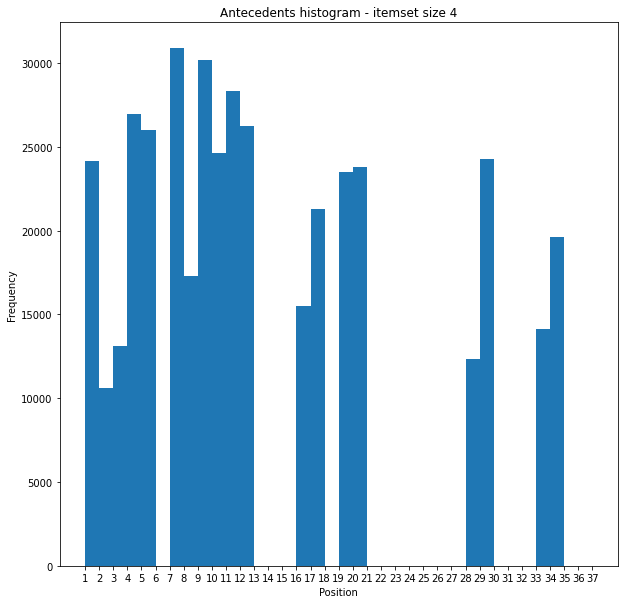

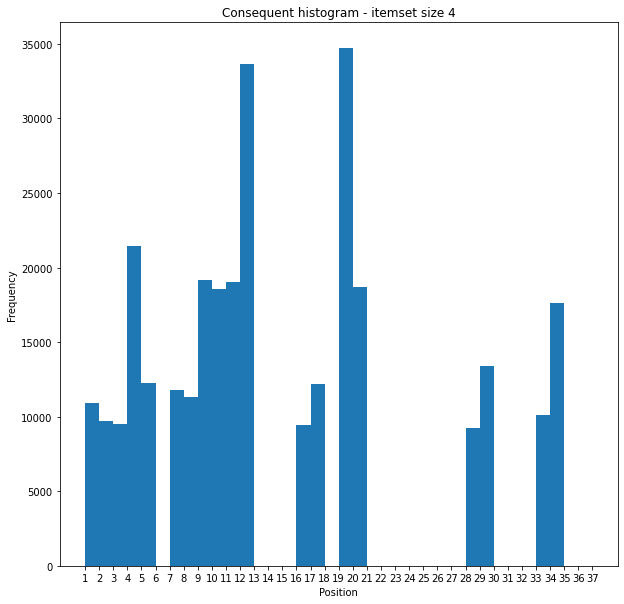

In [ ]:
# Codon file

pd.set_option('max_columns', 10, 'display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

itemset_size = 4

param_dict = {  
    "in_file": "https://raw.githubusercontent.com/kxk302/HIV/main/data/HIV_V3.fas_AA_macse_pre_tra.tsv",
    "min_support": 0.001, 
    "min_confidence": 0.050, 
    "min_lift": 2.0, 
    "min_conviction": 2.0, 
    "max_len": itemset_size,
    "codon": False
}

hiv_rules = get_association_rules_param(param_dict)

# Filter rules based on distance between head and tail positions
# Only valid is max_len is 2
# hiv_rules = filter_rules_based_on_distance(hiv_rules, 1)

num_rules = hiv_rules.shape[0]
hiv_rules = hiv_rules.sort_values('conviction', ascending=False)
# hiv_rules_sorted = hiv_rules.sort_values('distance', ascending=False)
print('Number of rules: {}'.format(num_rules))
print('HIV dataset association rules: ')
# print(hiv_rules_sorted.head(num_rules))
print(hiv_rules.head(num_rules))

# Histogram of positions in head and tail of rules
ante_hist_list = get_histogram_list(hiv_rules.iloc[:,0])
cons_hist_list = get_histogram_list(hiv_rules.iloc[:,1])

print(set(ante_hist_list))
print(set(cons_hist_list))

bins = list(range(1,38,1))

plot1 = plt.figure(1)
plot1.set_size_inches(10,10)
plt.title('Antecedents histogram - itemset size ' + str(itemset_size))
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(list(range(1,38)))
plt.hist(sorted(ante_hist_list), bins=bins)
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Antecedents_' + str(itemset_size) + '.png')

plot2 = plt.figure(2)
plot2.set_size_inches(10,10)
plt.title('Consequent histogram - itemset size ' + str(itemset_size))
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(list(range(1,38)))
plt.hist(sorted(cons_hist_list), bins=bins)
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Consequent_' + str(itemset_size) + '.png')


In [ ]:
hiv_rules.to_csv('/content/gdrive/MyDrive/Colab Notebooks/hiv_rules.csv',sep=',')

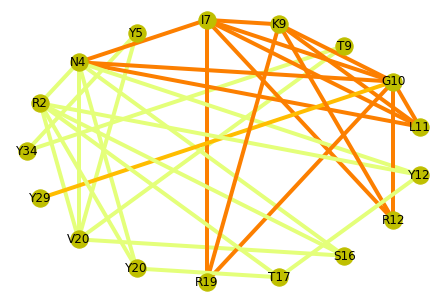

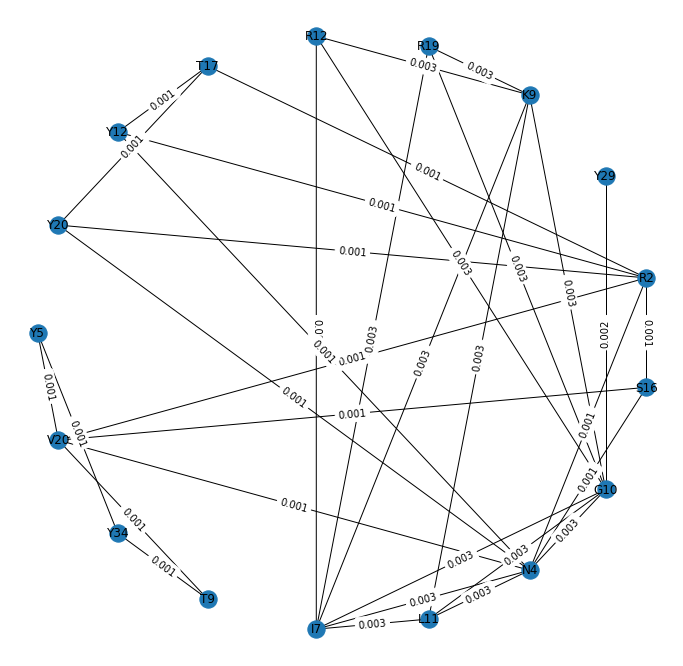

In [ ]:
import networkx as nx
import pylab as plt

G=nx.Graph()
num_top_rules = 20
# Add nodes and edges
for i, row in hiv_rules.head(num_top_rules).iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']: # Assign the maximum value in case of repetition
            if G.has_edge(ant, cons):
              weight = max(G[ant][cons]["weight"], row['support'])
            else:
              weight = row['support']
            G.add_edge(ant, cons, weight=weight)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.shell_layout(G)
labels_sorted = sorted(pos.keys(), key = lambda x: int(x[1:]), reverse=True)
pos_coords = list(pos.values()) # Get circular positions of the automated layout
pos_updated = {l:c for l, c in zip(labels_sorted, pos_coords)} # Now use the circular positions but in order of nucleotide positions

nx.draw(G, pos_updated, node_color='y', edgelist=edges, edge_color=weights, width=4.0, 
        edge_cmap=plt.cm.Wistia,with_labels = True)
plt.show()
weights = {e: round(G.edges[e]['weight'],3) for e in G.edges}

plt.figure(figsize=(12,12))

nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
nx.draw(G, pos, with_labels = True)

In [ ]:
plt.hist(sorted(ante_hist_list), 36)plt.hist(a_list, 5)!ls

HIV_V3_codonmsa_macse_pre.tsv  sample_data


In [ ]:
!more HIV_V3_codonmsa_macse_pre.tsv

Sample	Nucleotide	Position
0	T	2
1	C	2
2	C	2
3	C	2
4	C	2
5	T	2
6	C	2
7	T	2
8	T	2
9	C	2
10	T	2
11	C	2
12	C	2
13	C	2
14	C	2
15	C	2
16	C	2
17	T	2
18	T	2
19	C	2
20	T	2
21	T	2


In [ ]:
dd = pd.read_csv('HIV_V3_codonmsa_macse_pre.tsv',sep='\t')

In [ ]:
preprocess_input_file(dd)

Label,A10,A11,A12,A123,A124,...,T83,T84,T85,T86,T9
Sample,,,,,,,,,,,
0,0,1,0,0,0,...,0,0,0,0,0
1,0,1,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,1,0
4,0,0,0,0,0,...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1351,1,0,0,0,0,...,1,0,0,0,0
1352,0,1,0,0,0,...,0,0,1,0,0
1353,0,1,0,0,0,...,0,0,1,0,0
